In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula import api as smf
from statsmodels.api import OLS
from sklearn.linear_model import  LinearRegression, LogisticRegression, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_predict, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import ensemble
from xgboost import XGBClassifier
from collections import Counter
#from sklearn.model_selection import KFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import  classification_report,roc_auc_score, roc_curve, auc,roc_auc_score
from sklearn.metrics import mean_squared_error,confusion_matrix
%matplotlib inline

plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8) # (7,5) #(10,7)
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [9]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [10]:
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

1. discharge date should be at least 30 days ago
2. don't populate null (need this for cross validation)
3. get state/county instead of zip code (too many col when get_dummies.)
4. ensure scores(dischare) aren't populated with avg if null  

### Data Exploration

In [54]:
df = pd.read_csv('readmit7.csv')

In [55]:
df.shape

(86040, 70)

In [56]:
df.drop_duplicates()

,Readmit_Within_30Days,ReadmitInDays,PriorAdmitWithinOneYear,TotalAdmits_WithinLastYear,AvgLos,ExpectedMinusActualLos,EDVisits_WithinLast6Months,EncounterKey,PatientDurableKey,InpatientAdmissionDateKey,AdmitDate,DischargeDateKey,DischargeDate,Age,Sex,SmokingStatus,MaritalStatus,InCalifornia,PatientClass,HospitalService,AdmissionType,AdmissionSource,DischargeDisposition,PayorFinancialClass,AdmittingDepartmentType,DischargeDepartmentType,Admits_WithSameDiagnosis,OutpatientVisit_Canceled,LungTransplant,HeartTransplant,Vad,HospProblemCnt,LACE,TotalScore,MedicationScore,AssessmentScore,RiskScore,OrderScore,LineDrainAirwayScore,ActivitiesOfDailyLivingScore,CHF,CardiacArhythmias,ValvularDisease,PCD,PVD,HyperUncomp,Hypertension,Paralysis,CPD,ONeuroD,DiabetesUncomp,DiabetesComp,Hypothyroidism,RenalFailure,LiverDisease,PepticUlcerDEBleed,AIDSHIV,MetastaticCancer,SolidTumourWM,RheumatoidACD,Coagulopathy,Obesity,WeightLoss,FluidElectD,BloodLossAnaemia,DeficiencyAnaemia,AlcoholAbuse,DrugAbuse,Psychoses,Depression
0,0,0,0,0,1,-14.5,0,44336348,5656388,20160906,9/6/16,20160907,9/7/16,90,Male,Unknown,Married,1,Inpatient,Medicine,Elective,Home,Home,MEDICARE,Unspecified,Unspecified,1,1,0,0,0,1,low,0.00,0.00,0.0,0.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,-14.5,0,56077157,11178783,20171104,11/4/17,20171105,11/5/17,35,Male,Unknown,Married,1,Inpatient,Surgery,Trauma,Acute,Expired,MEDI-CAL,5-SCCT,5-SCCT,1,0,0,0,0,4,low,0.00,0.00,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,-14.3,0,69162357,1100716,20190328,3/28/19,20190329,3/29/19,81,Male,Light,Married,1,Inpatient,Medicine,Elective,Home,Home,MEDICARE,Unspecified,Unspecified,1,3,0,0,0,0,low,0.00,0.00,0.0,0.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,-14.3,0,69346016,3961819,20190401,4/1/19,20190402,4/2/19,71,Male,Light,Married,1,Inpatient,Medicine,Elective,Home,Home,MEDICARE,Unspecified,PACU,1,12,0,0,0,2,low,0.00,0.00,0.0,0.0,0.0,0.0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,-14.3,0,73800083,5504591,20190829,8/29/19,20190830,8/30/19,57,Female,Unknown,Married,1,Inpatient,Medicine,Elective,Home,Home,COMMERCIAL,Unspecified,PACU,1,4,0,0,0,0,low,0.00,0.00,0.0,0.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86035,1,30,1,33,9,4.7,228,54294954,5550696,20170909,9/9/17,20170916,9/16/17,88,Female,Unknown,Single,1,Inpatient,Medicine,Emergency,Home,Home,MEDICARE,Medical,Medical,32,326,0,0,0,8,high,0.00,0.00,0.0,0.0,0.0,0.0,0,1,1,1,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
86036,1,30,1,34,4,-0.9,145,54384187,5674730,20170913,9/13/17,20170916,9/16/17,54,Male,Unknown,Significant Other,1,Inpatient,Medicine,Emergency,Home,Home,MEDICARE,Unspecified,Unspecified,32,186,0,0,0,0,moderate,0.00,0.00,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
86037,1,30,1,35,5,0.0,266,61068637,1392564,20180603,6/3/18,20180607,6/7/18,50,Male,Light,Single,1,Inpatient,Medicine,Emergency,Home,Home,MEDICARE,Unspecified,Medical,29,733,0,0,0,0,high,0.00,0.00,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
86038,1,30,1,36,4,-0.1,118,39749608,5403442,20160219,2/19/16,20160224,2/24/16,89,Female,Unknown,Widowed,1,Inpatient,Medicine,Urgent,Clinic,Home,MEDICARE,Medical,Medical,33,245,0,0,0,1,high,0.00,0.00,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0


In [57]:
#unique patients 
len(df["PatientDurableKey"].drop_duplicates())

47485

In [16]:
# Categorical values
df.describe(include=['O']).T # ReadmitIn30Days , allow null, 

,count,unique,top,freq
Readmit_Within_30Days,86042,5,0,73985
ReadmitInDays,86041,1241,0,41709
PriorAdmitWithinOneYear,86041,4,0,41707
TotalAdmits_WithinLastYear,86041,82,0,28880
AdmitDate,86040,1461,2/13/2018,93
DischargeDate,86040,1471,10/4/2019,103
Sex,86040,3,Male,46843
SmokingStatus,86040,4,Unknown,49049
MaritalStatus,86040,8,Married,37250
PatientClass,86040,4,Inpatient,84701


In [17]:
# Numeric values
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AvgLos,86040.0,5.979010e+00,7.109001e+00,1.0,2.0,4.0,7.00,2.610000e+02
ExpectedMinusActualLos,86040.0,4.393282e-01,5.720355e+00,-29.6,-1.9,-0.5,1.40,2.505000e+02
EDVisits_WithinLast6Months,86040.0,9.238656e+00,3.609479e+01,0.0,0.0,1.0,6.00,7.930000e+02
EncounterKey,86040.0,5.807545e+07,1.112594e+07,11878434.0,49502883.0,58190218.5,67484300.75,7.753761e+07
PatientDurableKey,86040.0,5.997192e+06,3.769433e+06,634.0,4688712.5,5115167.0,5634666.00,1.728439e+07
InpatientAdmissionDateKey,86040.0,2.017638e+07,1.111750e+04,20160101.0,20170205.0,20180209.0,20190125.00,2.019123e+07
DischargeDateKey,86040.0,2.017654e+07,1.116548e+04,20160102.0,20170211.0,20180215.0,20190131.00,2.020011e+07
Age,86040.0,7.082091e+01,1.620941e+01,18.0,61.0,73.0,83.00,1.680000e+02
InCalifornia,86040.0,9.646327e-01,1.847074e-01,0.0,1.0,1.0,1.00,1.000000e+00
Admits_WithSameDiagnosis,86040.0,3.795026e+00,4.488949e+00,1.0,1.0,2.0,5.00,4.800000e+01


In [58]:
df.shape

(86040, 70)

In [61]:
#random sample to same size (reshuffle)
df = df.sample(df.shape[0]).reset_index(drop=True)

In [62]:
df.head().T

,0,1,2,3,4
Readmit_Within_30Days,0,0,0,0,1
ReadmitInDays,247,38,36,118,7
PriorAdmitWithinOneYear,1,1,1,1,1
TotalAdmits_WithinLastYear,1,8,2,33,8
AvgLos,2,7,14,4,3
ExpectedMinusActualLos,-0.4,-0.3,6.9,0.2,-0.9
EDVisits_WithinLast6Months,0,31,1,650,11
EncounterKey,57442754,68633365,54495168,50589528,40807693
PatientDurableKey,4720052,1416166,4995629,5648837,4962683
InpatientAdmissionDateKey,20180116,20190228,20170918,20170329,20160413


In [63]:
df['Readmit_Within_30Days'].value_counts()

0    73985
1    12055
Name: Readmit_Within_30Days, dtype: int64

In [50]:
df[df['DischargeDate'].isnull()==True]

,Readmit_Within_30Days,ReadmitInDays,PriorAdmitWithinOneYear,TotalAdmits_WithinLastYear,AvgLos,ExpectedMinusActualLos,EDVisits_WithinLast6Months,EncounterKey,PatientDurableKey,InpatientAdmissionDateKey,AdmitDate,DischargeDateKey,DischargeDate,Age,Sex,SmokingStatus,MaritalStatus,InCalifornia,PatientClass,HospitalService,AdmissionType,AdmissionSource,DischargeDisposition,PayorFinancialClass,AdmittingDepartmentType,DischargeDepartmentType,Admits_WithSameDiagnosis,OutpatientVisit_Canceled,LungTransplant,HeartTransplant,Vad,HospProblemCnt,LACE,TotalScore,MedicationScore,AssessmentScore,RiskScore,OrderScore,LineDrainAirwayScore,ActivitiesOfDailyLivingScore,CHF,CardiacArhythmias,ValvularDisease,PCD,PVD,HyperUncomp,Hypertension,Paralysis,CPD,ONeuroD,DiabetesUncomp,DiabetesComp,Hypothyroidism,RenalFailure,LiverDisease,PepticUlcerDEBleed,AIDSHIV,MetastaticCancer,SolidTumourWM,RheumatoidACD,Coagulopathy,Obesity,WeightLoss,FluidElectD,BloodLossAnaemia,DeficiencyAnaemia,AlcoholAbuse,DrugAbuse,Psychoses,Depression
86040,Warning: Null value is,eliminated by,an aggregate or other S,ET operation.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86041,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86042,(86040 rows affected),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
df['Readmit_Within_30Days'].value_counts(normalize=True)

0    0.859891
1    0.140109
Name: Readmit_Within_30Days, dtype: float64

In [65]:
drop_cols = ['ReadmitInDays','EncounterKey', 'PatientDurableKey', 'InpatientAdmissionDateKey','AdmitDate', 'DischargeDateKey', 'DischargeDate']

In [66]:
X = df.drop(['Readmit_Within_30Days'] + drop_cols, axis=1)
y = df['Readmit_Within_30Days']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

(array([73985.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 12055.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

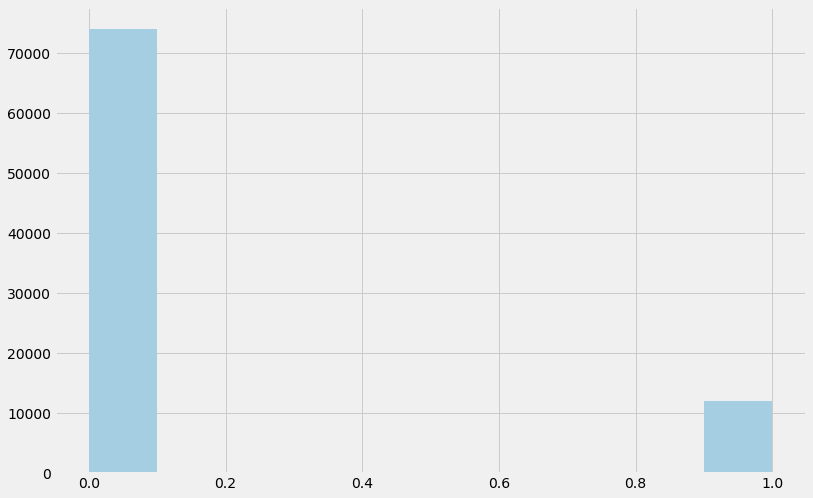

In [68]:
plt.hist(df['Readmit_Within_30Days'],label='Target Variable (Readmit Within 30Days)')

In [69]:
y_train.value_counts()

0    55467
1     9063
Name: Readmit_Within_30Days, dtype: int64

In [70]:
y_train.value_counts(normalize=True)

0    0.859554
1    0.140446
Name: Readmit_Within_30Days, dtype: float64

In [73]:
# Reduce data set to balance % redmit vs % No readmit
y_train_sub = y_train.loc[list(y_train[y_train==0].sample(9100).index) + list(y_train[y_train==1].index)]
X_train_sub = X_train.loc[y_train_sub.index]

In [74]:
y_train_sub.value_counts() 

0    9100
1    9063
Name: Readmit_Within_30Days, dtype: int64

In [75]:
X_train_sub.shape, y_train_sub.shape

((18163, 62), (18163,))

In [76]:
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train_sub, y_train_sub)

# Classification - Predict Readmssion within 30 days from discharge

## Encode Cateogory Values

In [77]:
from sklearn.preprocessing import OneHotEncoder

In [78]:
cat_features = [col for col,dtype in X_train.dtypes.items() if dtype=='object']
cat_feature_idxs = [i for i,dtype in enumerate(X_train.dtypes) if dtype=='object']

In [79]:
cat_features

['Sex',
 'SmokingStatus',
 'MaritalStatus',
 'PatientClass',
 'HospitalService',
 'AdmissionType',
 'AdmissionSource',
 'DischargeDisposition',
 'PayorFinancialClass',
 'AdmittingDepartmentType',
 'DischargeDepartmentType',
 'LACE']

In [80]:
# Encode Category Values to numeric 
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train_sub[cat_features])
X_train_sub_ohe = np.hstack((X_train_sub.drop(cat_features, axis=1).values, 
                             ohe.transform(X_train_sub[cat_features]).todense()))
X_test_sub_ohe = np.hstack((X_test_sub.drop(cat_features, axis=1).values, 
                             ohe.transform(X_test_sub[cat_features]).todense()))

In [81]:
X_train_sub_ohe

matrix([[ 1.,  6.,  2., ...,  0.,  0.,  1.],
        [ 0.,  2.,  7., ...,  0.,  1.,  0.],
        [ 1.,  4.,  5., ...,  1.,  0.,  0.],
        ...,
        [ 0.,  0., 13., ...,  0.,  1.,  0.],
        [ 1., 11.,  3., ...,  0.,  1.,  0.],
        [ 0.,  0.,  5., ...,  0.,  1.,  0.]])

In [82]:
X_train.shape, X_test.shape, X_train_sub_ohe.shape,X_test_sub_ohe.shape

((64530, 62), (21510, 62), (13622, 129), (4541, 129))

## Random Forest

In [83]:
rf = RandomForestClassifier(n_estimators=5)
rf.fit(X_train_sub_ohe, y_train_sub)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [84]:
print(classification_report(y_test_sub,  rf.predict(X_test_sub_ohe)))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      2273
           1       0.73      0.80      0.76      2268

    accuracy                           0.75      4541
   macro avg       0.75      0.75      0.75      4541
weighted avg       0.75      0.75      0.75      4541



In [85]:
roc_auc_score(y_test_sub, rf.predict_proba(X_test_sub_ohe)[:, 1])

0.8107246442596199

In [86]:
# Apply encoding category values on the test dataset
X_test_ohe = np.hstack((X_test.drop(cat_features, axis=1).values, 
                             ohe.transform(X_test[cat_features]).todense()))

In [87]:
print(classification_report(y_test,  rf.predict(X_test_ohe)))

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     18518
           1       0.29      0.79      0.43      2992

    accuracy                           0.70     21510
   macro avg       0.62      0.74      0.61     21510
weighted avg       0.86      0.70      0.75     21510



In [88]:
roc_auc_score(y_test, rf.predict_proba(X_test_ohe)[:, 1])

0.8060688566926933

## XGBoost

In [89]:
# Train on X_train_sub_ohe (subset of X_train reduced to balance %readmit & %not readmit and category encoding)
xgb = XGBClassifier(eval_metric='auc')
xgb.fit(X_train_sub_ohe, y_train_sub,
         early_stopping_rounds=20, eval_set=[(X_test_sub_ohe, y_test_sub)])

[0]	validation_0-auc:0.82824
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.829388
[2]	validation_0-auc:0.832794
[3]	validation_0-auc:0.830881
[4]	validation_0-auc:0.832794
[5]	validation_0-auc:0.833946
[6]	validation_0-auc:0.833372
[7]	validation_0-auc:0.834839
[8]	validation_0-auc:0.835137
[9]	validation_0-auc:0.836357
[10]	validation_0-auc:0.837009
[11]	validation_0-auc:0.837394
[12]	validation_0-auc:0.837485
[13]	validation_0-auc:0.837395
[14]	validation_0-auc:0.838764
[15]	validation_0-auc:0.839236
[16]	validation_0-auc:0.839231
[17]	validation_0-auc:0.839338
[18]	validation_0-auc:0.839669
[19]	validation_0-auc:0.840425
[20]	validation_0-auc:0.840336
[21]	validation_0-auc:0.840485
[22]	validation_0-auc:0.841082
[23]	validation_0-auc:0.841375
[24]	validation_0-auc:0.84153
[25]	validation_0-auc:0.841642
[26]	validation_0-auc:0.842123
[27]	validation_0-auc:0.841939
[28]	validation_0-auc:0.842189
[29]	validation_0-auc:0.842387
[30]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [90]:
y_pred_xgb = xgb.predict(X_test_ohe)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.59      0.74     18518
           1       0.28      0.98      0.43      2992

    accuracy                           0.64     21510
   macro avg       0.64      0.78      0.58     21510
weighted avg       0.90      0.64      0.69     21510



In [91]:
print(confusion_matrix(y_test, xgb.predict(X_test_ohe)))

[[10836  7682]
 [   52  2940]]


In [93]:
roc_auc_score(y_test, xgb.predict_proba(X_test_ohe)[:, 1])

0.8461176558665566

In [92]:
roc_auc_score(y_test_sub, xgb.predict_proba(X_test_sub_ohe)[:, 1])

0.8510392685858297

## Feature Selection

In [94]:
feature_importances = pd.Series(xgb.feature_importances_)

In [95]:
feature_importances.shape

(129,)

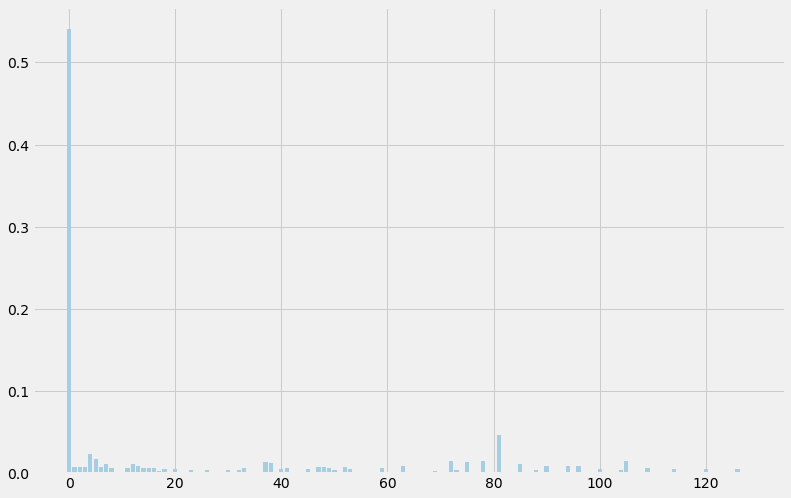

In [96]:
plt.bar(range(len(feature_importances)),feature_importances)
plt.show()

In [97]:
feature_importances.sort_values() #.index = X_train_sub.columns

64     0.000000
87     0.000000
86     0.000000
84     0.000000
83     0.000000
82     0.000000
80     0.000000
79     0.000000
77     0.000000
76     0.000000
74     0.000000
71     0.000000
70     0.000000
68     0.000000
67     0.000000
66     0.000000
65     0.000000
127    0.000000
62     0.000000
61     0.000000
60     0.000000
58     0.000000
57     0.000000
56     0.000000
89     0.000000
91     0.000000
92     0.000000
93     0.000000
125    0.000000
124    0.000000
123    0.000000
122    0.000000
121    0.000000
119    0.000000
118    0.000000
117    0.000000
116    0.000000
115    0.000000
113    0.000000
55     0.000000
112    0.000000
110    0.000000
108    0.000000
107    0.000000
106    0.000000
103    0.000000
102    0.000000
101    0.000000
99     0.000000
98     0.000000
97     0.000000
95     0.000000
111    0.000000
54     0.000000
128    0.000000
27     0.000000
21     0.000000
22     0.000000
24     0.000000
25     0.000000
28     0.000000
29     0.000000
31     0

In [98]:
top_features = pd.Series(xgb.feature_importances_).sort_values(ascending=False)
top_features = top_features[top_features > 0]

In [99]:
feature_importances.shape , top_features.shape

((129,), (55,))

In [100]:
top_features = pd.Series(xgb.feature_importances_).sort_values(ascending=False)

In [107]:
top_features[0], top_features[1], top_features[54]

(0.54081523, 0.008164332, 0.0)

In [108]:
top_features.index

Int64Index([  0,  81,   4,   5,  78, 105,  72,  37,  75,  38,
            ...
             76,  77,  79,  80,  82,  83,  84,  86,  87,  64],
           dtype='int64', length=129)

In [109]:
X_train_sub_ohe[:,top_features.index].shape

(13622, 129)

In [110]:
scores = []
for i in range(10,100):
    cv_scores = cross_val_score(xgb, X_train_sub_ohe[:, top_features[:i].index], y_train_sub,
                                cv=KFold(n_splits=4, shuffle=True))
    scores.append(cv_scores.mean())
    #clf = GrodSearchCV(estimator=svm, param_grid=p_grid, cv-cv_scores)
    #clf.fit()

In [112]:
cross_val_score(xgb, X_train_sub_ohe[:, top_features[:82].index], y_train_sub,
                                cv=KFold(n_splits=4, shuffle=True))

array([0.77480916, 0.78655314, 0.78384728, 0.79882526])

Text(0, 0.5, 'CV Score')

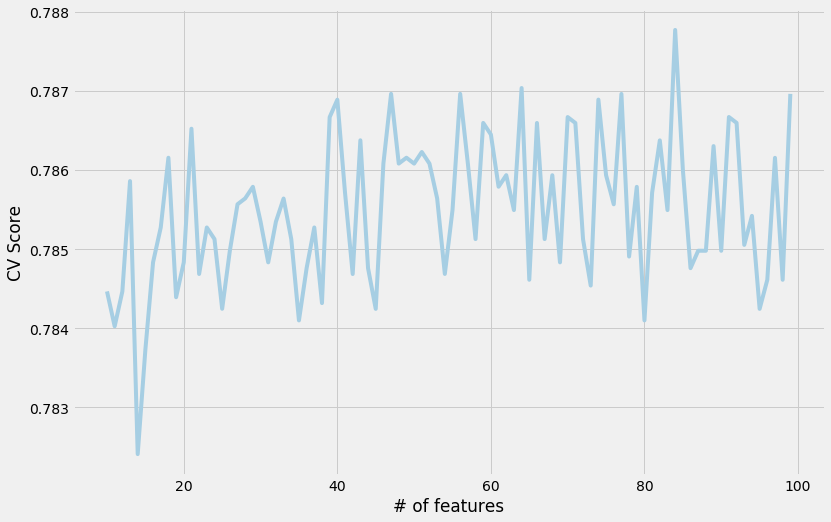

In [111]:
plt.figure(figsize=(12,8))
plt.plot(range(10,100), scores)
plt.xlabel('# of features')
plt.ylabel('CV Score')

#### Retrain modelS using the top features

In [113]:
xgb2 = XGBClassifier(eval_metric='auc')
xgb2.fit(X_train_sub_ohe[:,top_features[:82].index], y_train_sub,
         early_stopping_rounds=20, eval_set=[(X_test_sub_ohe[:,top_features[:82].index], y_test_sub)])

[0]	validation_0-auc:0.82824
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.829388
[2]	validation_0-auc:0.832794
[3]	validation_0-auc:0.830881
[4]	validation_0-auc:0.832794
[5]	validation_0-auc:0.833946
[6]	validation_0-auc:0.833372
[7]	validation_0-auc:0.834839
[8]	validation_0-auc:0.835137
[9]	validation_0-auc:0.836357
[10]	validation_0-auc:0.837009
[11]	validation_0-auc:0.837394
[12]	validation_0-auc:0.837485
[13]	validation_0-auc:0.837395
[14]	validation_0-auc:0.838764
[15]	validation_0-auc:0.839236
[16]	validation_0-auc:0.839231
[17]	validation_0-auc:0.839338
[18]	validation_0-auc:0.839669
[19]	validation_0-auc:0.840425
[20]	validation_0-auc:0.840336
[21]	validation_0-auc:0.840485
[22]	validation_0-auc:0.841082
[23]	validation_0-auc:0.841375
[24]	validation_0-auc:0.84153
[25]	validation_0-auc:0.841642
[26]	validation_0-auc:0.842123
[27]	validation_0-auc:0.841939
[28]	validation_0-auc:0.842189
[29]	validation_0-auc:0.842387
[30]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [114]:
print(classification_report(y_test_sub, xgb2.predict(X_test_sub_ohe[:,top_features[:82].index])))

              precision    recall  f1-score   support

           0       0.97      0.60      0.74      2273
           1       0.71      0.98      0.82      2268

    accuracy                           0.79      4541
   macro avg       0.84      0.79      0.78      4541
weighted avg       0.84      0.79      0.78      4541



In [116]:
roc_auc_score(y_test, xgb2.predict_proba(X_test_ohe[:,top_features[:82].index])[:, 1])

0.8461176558665566

In [115]:
roc_auc_score(y_test_sub, xgb2.predict_proba(X_test_sub_ohe[:,top_features[:82].index])[:, 1])

0.8510392685858297

In [118]:
rf2 = RandomForestClassifier()
rf2.fit(X_train_sub_ohe[:,top_features[:82].index], y_train_sub)

roc_auc_score(y_test_sub, rf2.predict_proba(X_test_sub_ohe[:,top_features[:82].index])[:, 1])

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8216576621034752

In [119]:
roc_auc_score(y_test, rf2.predict_proba(X_test_ohe[:,top_features[:82].index])[:, 1])

0.8222397195704367

In [120]:
print(classification_report(y_test_sub, rf2.predict(X_test_sub_ohe[:,top_features[:82].index])))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      2273
           1       0.73      0.79      0.76      2268

    accuracy                           0.75      4541
   macro avg       0.75      0.75      0.75      4541
weighted avg       0.75      0.75      0.75      4541



## Gradient Boosting Classifier

In [155]:
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.model_selection import train_test_split

print(__doc__)

#data_list = [datasets.load_iris(), datasets.load_digits()]
#data_list = [(d.data, d.target) for d in data_list]
#data_list += [datasets.make_hastie_10_2()]
#names = ['Iris Data', 'Digits Data', 'Hastie Data']

n_gb = []
score_gb = []
time_gb = []
n_gbes = []
score_gbes = []
time_gbes = []

n_estimators = 500

#for X, y in data_list:
#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
#                                                        random_state=0)

    # We specify that if the scores don't improve by atleast 0.01 for the last
    # 10 stages, stop fitting additional stages
gbes = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                           validation_fraction=0.2,
                                           n_iter_no_change=5, tol=0.01,
                                           random_state=0)
gb = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                         random_state=0)
start = time.time()
gb.fit(X_train_sub_ohe, y_train_sub)
time_gb.append(time.time() - start)

start = time.time()
gbes.fit(X_train_sub_ohe, y_train_sub)
time_gbes.append(time.time() - start)

score_gb.append(gb.score(X_test_sub_ohe, y_test_sub))
score_gbes.append(gbes.score(X_test_sub_ohe, y_test_sub))

n_gb.append(gb.n_estimators_)
n_gbes.append(gbes.n_estimators_)

print(n_gb)
print(n_gbes)
print(classification_report(y_test_sub, gb.predict(X_test_sub_ohe)))
print(classification_report(y_test_sub, gbes.predict(X_test_sub_ohe)))

#bar_width = 0.2
#n = len(data_list)
#index = np.arange(0, n * bar_width, bar_width) * 2.5
#index = index[0:n]

Automatically created module for IPython interactive environment
[500]
[31]
              precision    recall  f1-score   support

           0       0.90      0.66      0.76      2273
           1       0.73      0.93      0.82      2268

    accuracy                           0.79      4541
   macro avg       0.81      0.79      0.79      4541
weighted avg       0.81      0.79      0.79      4541

              precision    recall  f1-score   support

           0       1.00      0.58      0.74      2273
           1       0.71      1.00      0.83      2268

    accuracy                           0.79      4541
   macro avg       0.85      0.79      0.78      4541
weighted avg       0.85      0.79      0.78      4541



## ROC Curve

In [121]:
X_test_ohe[:, top_features[:82].index]

matrix([[0., 1., 2., ..., 0., 1., 0.],
        [1., 1., 7., ..., 0., 0., 0.],
        [1., 1., 8., ..., 0., 0., 0.],
        ...,
        [1., 1., 9., ..., 0., 0., 0.],
        [0., 1., 7., ..., 0., 0., 0.],
        [0., 1., 3., ..., 0., 0., 0.]])

In [122]:
y_test.shape, X_test_ohe.shape

((21510,), (21510, 129))

In [123]:
X_test_ohe[:,top_features.index].shape

(21510, 129)

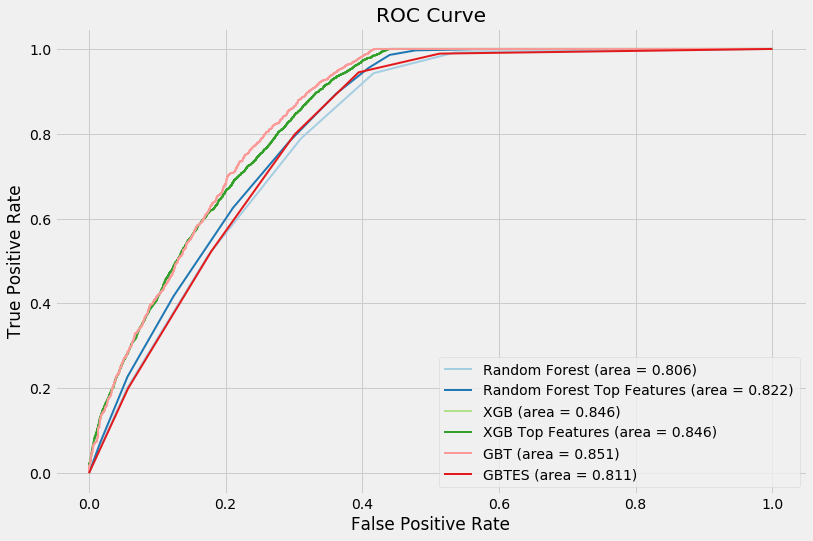

In [153]:
plt.figure(figsize=(12,8))
# calculate roc curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test_ohe)[:,1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb.predict_proba(X_test_ohe)[:,1])

fpr_rf_top, tpr_rf_top, _ = roc_curve(y_test, rf2.predict_proba(X_test_ohe[:,top_features[:82].index])[:, 1])
fpr_xgb_top, tpr_xgb_top, _ = roc_curve(y_test, xgb2.predict_proba(X_test_ohe[:,top_features[:82].index])[:, 1]) 

fpr_gbes, tpr_gbes, _ = roc_curve(y_test_sub, rf.predict_proba(X_test_sub_ohe)[:,1])
fpr_gb, tpr_gb, _ = roc_curve(y_test_sub, xgb.predict_proba(X_test_sub_ohe)[:,1])

#fpr_gbes_top, tpr_gbes_top, _ = roc_curve(y_test_sub, gbes.predict_proba(X_test_sub_ohe[:,top_features[:82].index])[:, 1])
#fpr_gb_top, tpr_gb_top, _ = roc_curve(y_test_sub, gb.predict_proba(X_test_sub_ohe[:,top_features[:82].index])[:, 1]) 



# plot the roc curve for the model
lw=2
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, lw=lw, label='Random Forest (area = {:.03f})'.format(roc_auc_rf))
roc_auc_rf_top = auc(fpr_rf_top, tpr_rf_top)
plt.plot(fpr_rf_top, tpr_rf_top, lw=lw, label='Random Forest Top Features (area = {:.03f})'.format(roc_auc_rf_top))

roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, lw=lw, label='XGB (area = {:.03f})'.format(roc_auc_xgb))
roc_auc_xgb_top = auc(fpr_xgb_top, tpr_xgb_top)
plt.plot(fpr_xgb_top, tpr_xgb_top, lw=lw, label='XGB Top Features (area = {:.03f})'.format(roc_auc_xgb_top))
    
roc_auc_gbes = auc(fpr_gbes, tpr_gbes)
plt.plot(fpr_gbes, tpr_gbes, lw=lw, label='GBTES (area = {:.03f})'.format(roc_auc_gbes))
roc_auc_gb = auc(fpr_gb, tpr_gb)
plt.plot(fpr_gb, tpr_gb, lw=lw, label='GBT (area = {:.03f})'.format(roc_auc_gb))

#
#roc_auc_gb_top = auc(fpr_gb_top, tpr_gb_top)
#plt.plot(fpr_gb_top, tpr_gb_top, lw=lw, label='GB Top Features (area = {:.03f})'.format(roc_auc_gb_top))
    
# pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# show the legend
plt.legend()

## Feature Importance

In [149]:
X_test[index=pd.Series(gb.feature_importances_).sort_values().index]

SyntaxError: invalid syntax (<ipython-input-149-c325623d3aaf>, line 1)

In [137]:
feature_importanceas = pd.Series(rf.feature_importances_)

In [138]:
feature_importances.index = X_test.columns

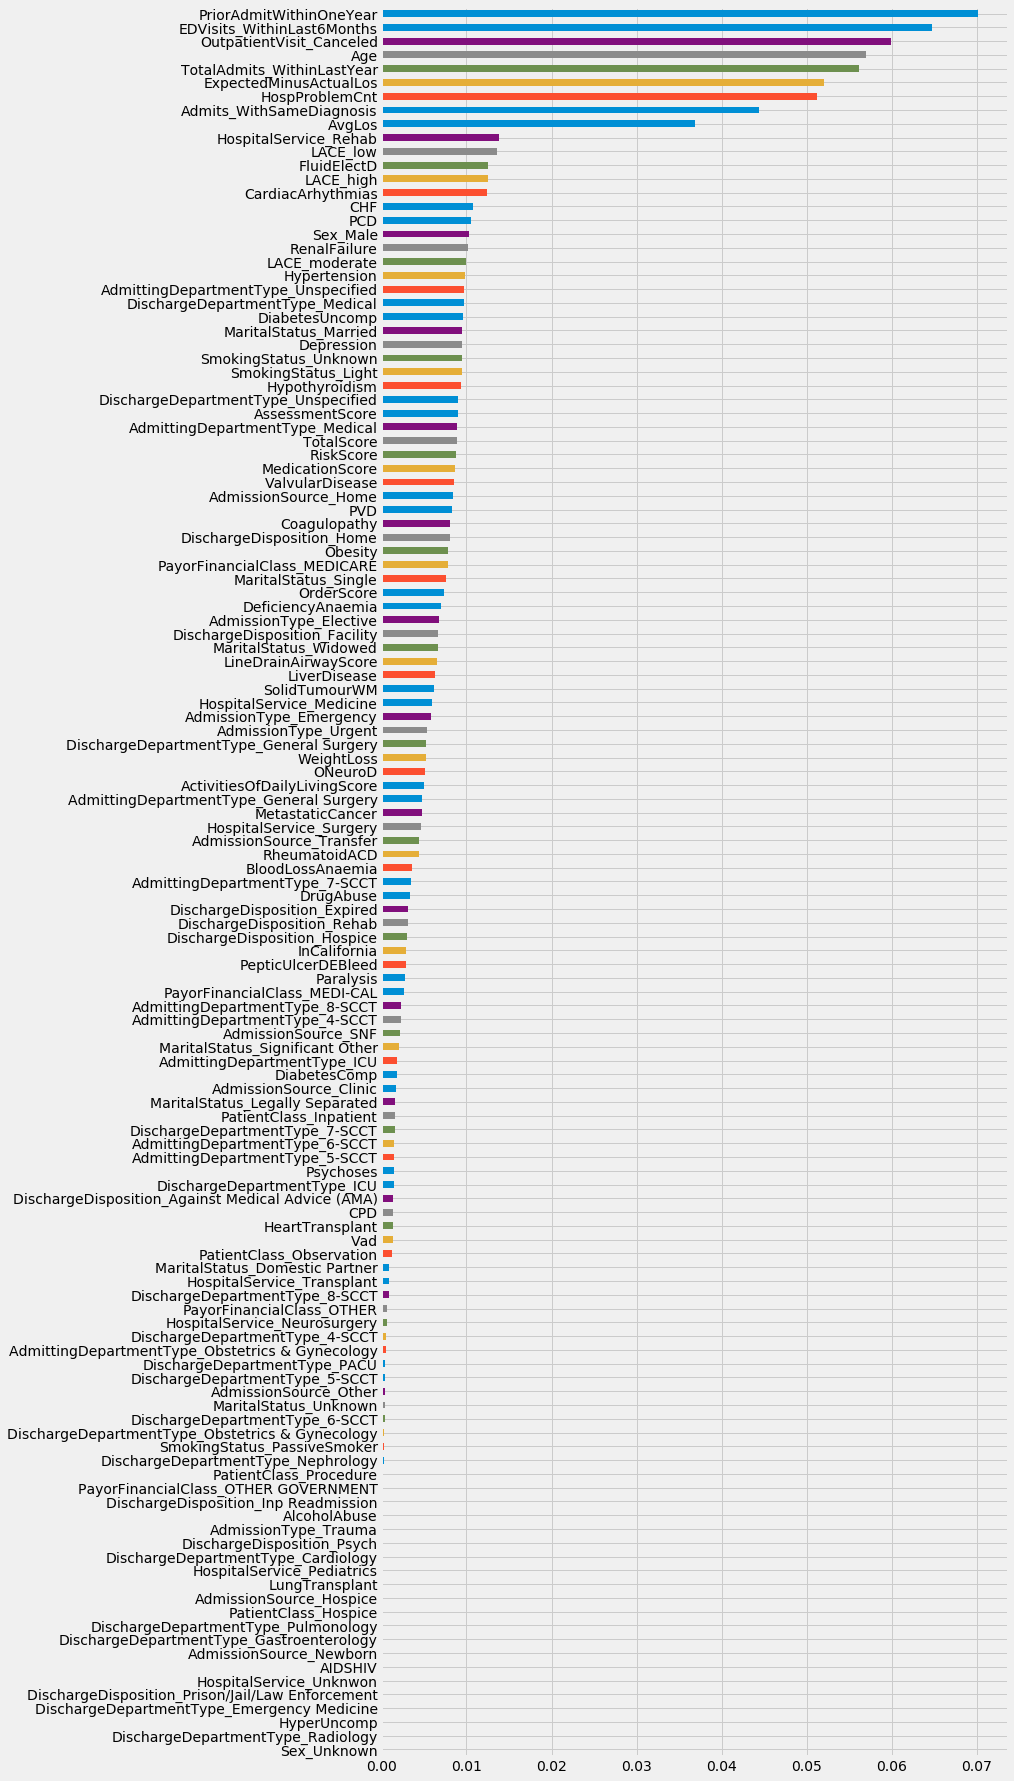

In [139]:
feature_importances.index = X_test.columns
plt.rcParams['figure.figsize'] = (10,30)
feature_importances = feature_importances.sort_values()
feature_importances.plot('barh')

# Regression - Predict Number of days until Readmission

### Random Forest Regression - predict number of days until readmission

In [191]:
df3 = df.drop(['Readmit_Within_30Days'], axis = 1)

In [196]:
df3.columns

Index(['ReadmitInDays', 'PriorAdmitWithinOneYear',
       'TotalAdmits_WithinLastYear', 'AvgLos', 'ExpectedMinusActualLos',
       'EDVisits_WithinLast6Months', 'EncounterKey', 'PatientDurableKey',
       'Age', 'InCalifornia',
       ...
       'DischargeDepartmentType_General Surgery',
       'DischargeDepartmentType_ICU', 'DischargeDepartmentType_Medical',
       'DischargeDepartmentType_Nephrology',
       'DischargeDepartmentType_Obstetrics & Gynecology',
       'DischargeDepartmentType_PACU', 'DischargeDepartmentType_Unspecified',
       'LACE_high', 'LACE_low', 'LACE_moderate'],
      dtype='object', length=124)

In [192]:
df_train, df_test = train_test_split(df3, test_size=0.2)

In [193]:
df_train.shape, df_test.shape

((38216, 124), (9554, 124))

In [197]:
X_train = df_train.drop(['ReadmitInDays'],axis=1)
X_test = df_test.drop(['ReadmitInDays'],axis=1)
y_train = df_train['ReadmitInDays']
y_test = df_test['ReadmitInDays']

In [198]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [200]:
lr.intercept_

-237.9467664059862

In [201]:
y_pred_train = lr.predict(X_train)
print('RMSE for Train: {}'.format(rmse(y_train, y_pred_train)))
print('Mean Squared Error for Train: {}'.format(mse(y_train, y_pred_train)))

y_pred_test = lr.predict(X_test)
print('RMSE for Test: {}'.format(rmse(y_test, y_pred_test)))
print('Mean Squared Error for Test: {}'.format(mse(y_test, y_pred_test)))

RMSE for Train: 78.92494536635542
Mean Squared Error for Train: 6229.147001082187
RMSE for Test: 79.40808890547548
Mean Squared Error for Test: 6305.644583619899


Text(0, 0.5, 'Absolute Residual: abs(y_pred_train - y_true)')

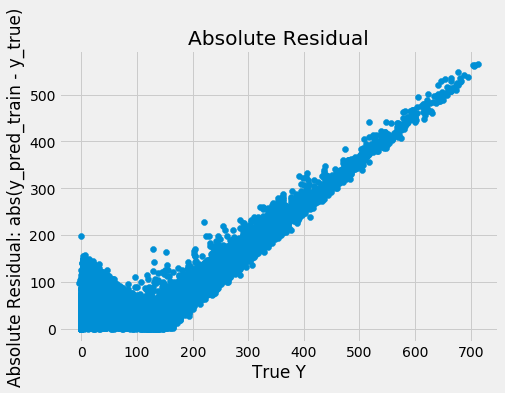

In [202]:
plt.scatter(y_train,  np.abs(y_train - y_pred_train))
plt.title('Absolute Residual')
plt.xlabel('True Y')
plt.ylabel('Absolute Residual: abs(y_pred_train - y_true)')

### Statsmodel

In [204]:
statsmodel = sm.OLS(y_train, X_train)
result = statsmodel.fit()

In [205]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ReadmitInDays   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     184.8
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        14:45:09   Log-Likelihood:            -2.2117e+05
No. Observations:               38216   AIC:                         4.426e+05
Df Residuals:                   38094   BIC:                         4.436e+05
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
PriorAdmitWithinOneYear                             132.6463      1.036    128.006      0.000     130.615     134.677
TotalAdmits_WithinLastYear                           -1.4623      0.313     -4.676      0.000      -2.075      -0.849
AvgLos                                               -0.2891      0.142     -2.031      0.042      -0.568      -0.010
ExpectedMinusActualLos                                0.3014      0.160      1.883      0.060      -0.012       0.615
EDVisits_WithinLast6Months                            0.0594      0.028      2.155      0.031       0.005       0.113
EncounterKey                                       9.187e-07   1.04e-07      8.826      0.000    7.15e-07    1.12e-06
PatientDurableKey                                 -9.054e-07   9.64e-08     -9.394      0.000   -1.09e-06   -7.16e-07
Age                                                   0.1880      0.036      5.190      0.000       0.117       0.259
InCalifornia                                          4.5659      2.295      1.990      0.047       0.068       9.064
Admits_WithSameDiagnosis                             -5.6359      0.418    -13.481      0.000      -6.455      -4.816
OutpatientVisit_Canceled                             -0.0006      0.007     -0.089      0.929      -0.015       0.013
LungTransplant                                      -21.1179     22.046     -0.958      0.338     -64.329      22.093
HeartTransplant                                       5.8819      4.029      1.460      0.144      -2.016      13.780
Vad                                                   2.2470      3.786      0.594      0.553      -5.173       9.667
HospProblemCnt                                        0.3207      0.081      3.954      0.000       0.162       0.480
TotalScore                                           -0.0196      0.083     -0.235      0.814      -0.183       0.144
MedicationScore                                       0.0850      0.112      0.758      0.449      -0.135       0.305
AssessmentScore                                       0.0263      0.099      0.267      0.789      -0.167       0.219
RiskScore                                             0.1770      0.129      1.374      0.169      -0.075       0.429
OrderScore                                            0.0195      0.083      0.234      0.815      -0.144       0.183
LineDrainAirwayScore                                 -0.3795      0.253     -1.501      0.133      -0.875       0.116
ActivitiesOfDailyLivingScore                          0.5025      0.263      1.909      0.056      -0.013       1.018
CHF                                                   1.9980      1.024      1.951      0.051      -0.009       4.005
CardiacArhythmi